In [1]:
import numpy as np
from numpy import ogrid, repeat, newaxis
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

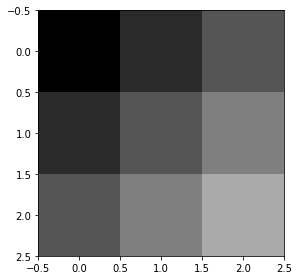

In [2]:
# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

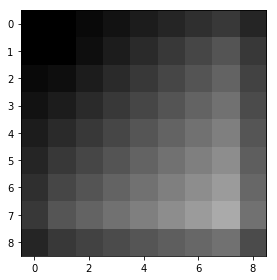

In [3]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # Pad with 0 values, similar to how Tensorflow does it.
    # Order=1 is bilinear upsampling
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

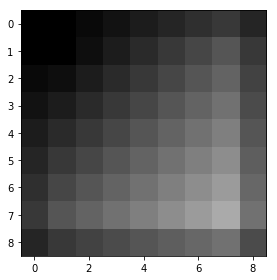

In [5]:
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor,
                                        number_of_classes)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                        output_shape=[1, new_height, new_width, number_of_classes],
                        strides=[1, factor, factor, 1])

                final_result = sess.run(res,
                                feed_dict={upsample_filt_pl: upsample_filter_np,
                                           logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)